# Whisper transcription on the FLEURS dataset
Only on the downloaded part of it (approx. 10 languages for which I found a multilingual NeMo model as comparision). The manifests need to be generated beforehand.

In [1]:
# if faster_whisper fails silently, chances are this will solve it: sudo apt install nvidia-cudnn # ipynb does not show all errors properly; I recommend running the problematic scripts directly from the terminal

import whisper
import json
from tqdm.notebook import tqdm
from faster_whisper import WhisperModel
import os

/home/kozi/Documents/_onlab_git/ami/tinydiarize/whisper/timing.py:57: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):


In [2]:
# download a dedicated faster_whisper_model
def download_faster_whisper_model(model_path_or_name):
    model = WhisperModel(model_path_or_name, device="cuda", compute_type="int8", local_files_only = False)
    return model

#model = download_faster_whisper_model('bababababooey/faster-whisper-large-v3') # 'large-v3'
#model

In [3]:
def load_whisper_model(model_path_or_name):
    model = whisper.load_model(model_path_or_name, device="cuda")#.to(torch.device("cpu"))
    return model


def load_faster_whisper_model(model_path_or_name):
    # this can load even large models
    if model_path_or_name == 'large-v3':
        model = WhisperModel('bababababooey/faster-whisper-large-v3', device="cuda", compute_type="int8", local_files_only = True)
        model.feature_extractor.mel_filters = model.feature_extractor.get_mel_filters(model.feature_extractor.sampling_rate, model.feature_extractor.n_fft, n_mels=128)
    else:
        model = WhisperModel(model_path_or_name, device="cuda", compute_type="int8", local_files_only = True)
    return model


# faster_whisper is faster than openai's implementation
def whisper_transcribe_from_manifest(model, manifest_path, output_path, openai_whisper=False):
    results = []

    with open(manifest_path, 'r') as fin:
        lines = fin.readlines()
        print("read file {}".format(manifest_path))
        for line in tqdm(lines):
            # load() for whole document, loads() for string
            manifest_entry = json.loads(line)
            #print(manifest_entry['audio_filepath'])

            if openai_whisper:
                result = model.transcribe(manifest_entry['audio_filepath'])
            else:
                segments, _ = model.transcribe(manifest_entry['audio_filepath'], beam_size=1, best_of=1) #  beam_size=1, best_of=1
                segments = list(segments)  # The transcription will actually run here.)
                result = ""
                for segment in segments:
                    result += segment.text
                #print(result)

            results.append({
                "audio_filepath": manifest_entry['audio_filepath'],
                "duration": manifest_entry['duration'],
                "text": manifest_entry['text'],
                "pred_text": result
            })

    with open(output_path, "w") as fout:
        for result in results:
            # ensure_ascii=True is the default and even speech_transcribe will use escaped umlauts, but this way the manifest is human-readable
            fout.write(json.dumps(result, ensure_ascii=False) + "\n")   
    print("wrote file {}".format(output_path))

In [7]:
# run faster-whisper transcription for the downloaded fleurs dataset (manifests need to be generated beforehand)
# fleurs_dataset_dirs = ["be_by", "de_de", "en_us", "fr_fr", "gl_es", "hr_hr", "hu_hu", "it_it", "pl_pl", "ru_ru", "uk_ua"]

# large model does not fit into 4GB of VRAM (even medium can become problematic)
# actually it does with cudnn, see ref. https://github.com/guillaumekln/faster-whisper#large-v2-model-on-gpu
for model_name in ["tiny", "base", "small", "medium", "large", "large-v2", "large-v3"]: 
    model = load_faster_whisper_model(model_name)
    print("loaded model {}".format(model_name))

    for child_item in os.listdir("/home/kozi/Documents/fleurs/"):
        child_dir = os.path.join("/home/kozi/Documents/fleurs/", child_item)
        if not os.path.isdir(child_dir):
            continue

        input_manifest_path = os.path.join(child_dir, "whisper_manifest.json")
        if not os.path.isfile(input_manifest_path):
            continue

        output_manifest_path = os.path.join(child_dir, "whisper_transcription_{}_{}.json".format(child_item, model_name))
        if os.path.isfile(output_manifest_path):
            continue

        whisper_transcribe_from_manifest(
            model,
            input_manifest_path,
            output_path = output_manifest_path,
            openai_whisper = False
        )

loaded model tiny
loaded model base
loaded model small
loaded model medium
loaded model large
loaded model large-v2
loaded model large-v3
read file /home/kozi/Documents/fleurs/hu_hu/whisper_manifest.json


  0%|          | 0/905 [00:00<?, ?it/s]

wrote file /home/kozi/Documents/fleurs/hu_hu/whisper_transcription_hu_hu_large-v3.json


In [5]:
# run faster-whisper transcription for the downloaded librispeech dataset (manifests need to be generated beforehand)
# fleurs_dataset_dirs = ["be_by", "de_de", "en_us", "fr_fr", "gl_es", "hr_hr", "hu_hu", "it_it", "pl_pl", "ru_ru", "uk_ua"]

# large model does not fit into 4GB of VRAM (even medium can become problematic)
# actually it does with cudnn, see ref. https://github.com/guillaumekln/faster-whisper#large-v2-model-on-gpu
for model_name in ["tiny", "base", "small", "medium", "large", "large-v2", "large-v3"]: 
    model = load_faster_whisper_model(model_name)
    print("loaded model {}".format(model_name))

    input_manifest_path = "/home/kozi/Documents/librispeech_get_test_dataset/data/test_other_whisper.json"

    output_manifest_path = "/home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/whisper_transcription_librispeech_{}.json".format(model_name)
    if os.path.isfile(output_manifest_path):
        continue

    whisper_transcribe_from_manifest(
        model,
        input_manifest_path,
        output_path = output_manifest_path,
        openai_whisper = False
    )

loaded model tiny
read file /home/kozi/Documents/librispeech_get_test_dataset/data/test_other_whisper.json


  0%|          | 0/2939 [00:00<?, ?it/s]

wrote file /home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/whisper_transcription_librispeech_tiny.json
loaded model base
read file /home/kozi/Documents/librispeech_get_test_dataset/data/test_other_whisper.json


  0%|          | 0/2939 [00:00<?, ?it/s]

wrote file /home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/whisper_transcription_librispeech_base.json
loaded model small
read file /home/kozi/Documents/librispeech_get_test_dataset/data/test_other_whisper.json


  0%|          | 0/2939 [00:00<?, ?it/s]

wrote file /home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/whisper_transcription_librispeech_small.json
loaded model medium
read file /home/kozi/Documents/librispeech_get_test_dataset/data/test_other_whisper.json


  0%|          | 0/2939 [00:00<?, ?it/s]

wrote file /home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/whisper_transcription_librispeech_medium.json


RuntimeError: CUDA failed with error out of memory

In [1]:
# script to calculate results for librispeech dataset
# my nemo2 install broke somehow so this script no longer runs (probably because of a torch update issue, but it should not have updated)
# use mahmoud_whisper conda environment or the jiwer script below

!python3 /home/kozi/Documents/NeMo/examples/asr/speech_to_text_eval.py \
    dataset_manifest='/home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/out_large_CER_1.json' \
    use_cer=True \
    only_score_manifest=True

# 15 minutes
!python3 /home/kozi/Documents/NeMo/examples/asr/speech_to_text_eval.py \
    dataset_manifest='/home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/whisper_transcription_librispeech_tiny.json' \
    use_cer=True \
    only_score_manifest=True

# 20 minutes
!python3 /home/kozi/Documents/NeMo/examples/asr/speech_to_text_eval.py \
    dataset_manifest='/home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/whisper_transcription_librispeech_base.json' \
    use_cer=True \
    only_score_manifest=True

# 40 minutes
!python3 /home/kozi/Documents/NeMo/examples/asr/speech_to_text_eval.py \
    dataset_manifest='/home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/whisper_transcription_librispeech_small.json' \
    use_cer=True \
    only_score_manifest=True

# 2 hours
!python3 /home/kozi/Documents/NeMo/examples/asr/speech_to_text_eval.py \
    dataset_manifest='/home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/whisper_transcription_librispeech_medium.json' \
    use_cer=True \
    only_score_manifest=True

Traceback (most recent call last):
  File "/home/kozi/Documents/NeMo/examples/asr/speech_to_text_eval.py", line 65, in <module>
    import transcribe_speech
  File "/home/kozi/Documents/NeMo/examples/asr/transcribe_speech.py", line 24, in <module>
    from nemo.collections.asr.metrics.rnnt_wer import RNNTDecodingConfig
  File "/home/kozi/anaconda3/envs/mahmoud_whisper/lib/python3.10/site-packages/nemo/collections/asr/__init__.py", line 15, in <module>
    from nemo.collections.asr import data, losses, models, modules
  File "/home/kozi/anaconda3/envs/mahmoud_whisper/lib/python3.10/site-packages/nemo/collections/asr/losses/__init__.py", line 16, in <module>
    from nemo.collections.asr.losses.audio_losses import SDRLoss
  File "/home/kozi/anaconda3/envs/mahmoud_whisper/lib/python3.10/site-packages/nemo/collections/asr/losses/audio_losses.py", line 21, in <module>
    from nemo.collections.asr.parts.preprocessing.features import make_seq_mask_like
  File "/home/kozi/anaconda3/envs/mahmo

In [5]:
# trim trailing whitespace in VSC: Ctrl-K Ctrl-X
# okay well Whisper uses punctuation but Librispeech is all lowercase with only spaces so a little creativity is needed to make this work

import json
from jiwer import wer
import os
import re

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove all non-alphabetic characters and extra spaces
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def calculate_weighted_average_wer(json_lines):
    total_wer = 0.0
    total_words = 0
    wer_list = []

    for line in json_lines:
        # Parse JSON line
        data = json.loads(line)

        # Text and predicted text
        reference = preprocess_text(data["text"])
        hypothesis = preprocess_text(data["pred_text"])

        # Calculate WER for this line
        rate = wer(reference, hypothesis)

        # Number of words in the reference text (weight)
        num_words = len(reference.split())

        # Add the weighted contribution to total WER
        total_wer += rate * num_words
        total_words += num_words

    # Calculate the weighted average WER
    if total_words > 0:
        average_wer = total_wer / total_words
    else:
        average_wer = 0.0

    return average_wer * 100

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

base_path = '/home/kozi/Documents/_onlab_git/output/librispeech_get_test_dataset/'
for file in ['out_large_CER_1.json', 'whisper_transcription_librispeech_base.json', 'whisper_transcription_librispeech_medium.json', 'whisper_transcription_librispeech_small.json', 'whisper_transcription_librispeech_tiny.json']:
    json_lines = read_json_file(os.path.join(base_path, file))
    average_wer_percentage = calculate_weighted_average_wer(json_lines)
    print(f"{file}: {average_wer_percentage:.2f}%")

out_large_CER_1.json: 4.31%
whisper_transcription_librispeech_base.json: 13.47%
whisper_transcription_librispeech_medium.json: 8.08%
whisper_transcription_librispeech_small.json: 9.30%
whisper_transcription_librispeech_tiny.json: 17.96%


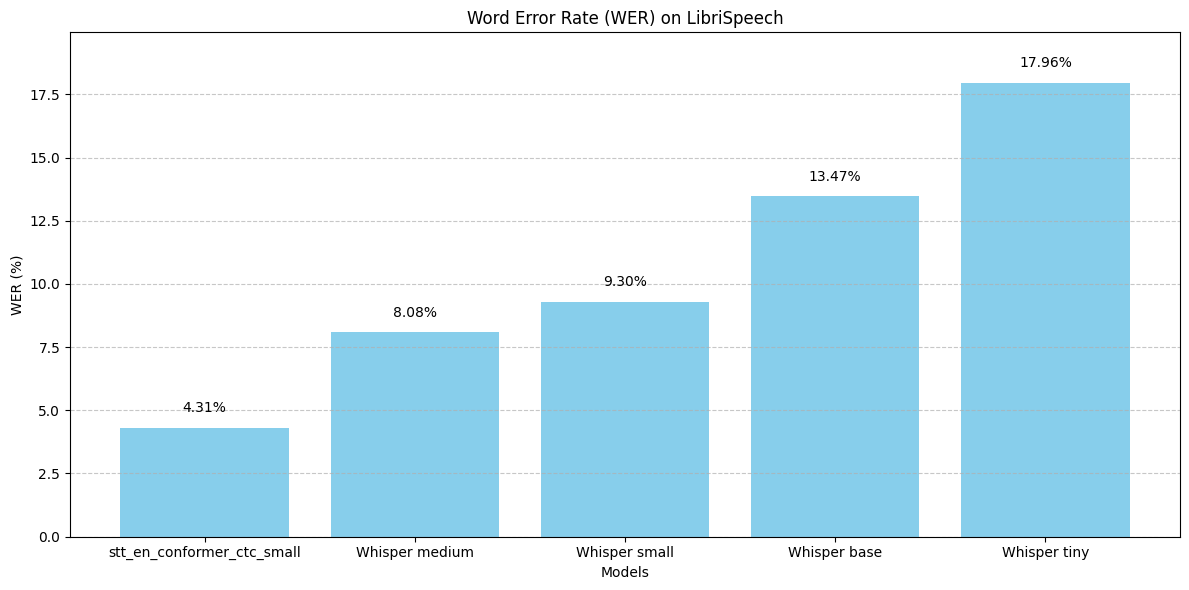

In [18]:
import matplotlib.pyplot as plt

# WER results to visualize
wer_results = {
    "stt_en_conformer_ctc_small": 4.31,
    "Whisper medium": 8.08,
    "Whisper small": 9.30,
    "Whisper base": 13.47,
    "Whisper tiny": 17.96
}

# Extract labels and WER values from the dictionary
labels = list(wer_results.keys())
wer_percentages = list(wer_results.values())

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(labels, wer_percentages, color='skyblue')
plt.xlabel('Models')
plt.ylabel('WER (%)')
plt.title('Word Error Rate (WER) on LibriSpeech')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(wer_percentages) + 2)

# Add percentage labels on top of the bars
for i, wer in enumerate(wer_percentages):
    plt.text(i, wer + 0.5, f'{wer:.2f}%', ha='center', va='bottom')

# Show the plot
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

In [32]:
# calculate WER results for large whisper models (large, larve-v2)

import json
from jiwer import wer
import os
import re

def traverse_fleurs(skip_Hungarian=False):
    fleurs_dataset_dirs = ["de_de", "en_us", "fr_fr", "gl_es", "hr_hr", "hu_hu", "it_it", "pl_pl"] # "be_by", "ru_ru", "uk_ua"
    results = {}

    for subdir_string in fleurs_dataset_dirs:
        if skip_Hungarian and subdir_string == "hu_hu":
            continue

        subdir = os.path.join("/home/kozi/Documents/_onlab_git/output/fleurs/", subdir_string)
        for file in os.listdir(subdir):
            if file.startswith("whisper") and file.endswith(".json") and "large" in file:
                file = os.path.join(subdir, file)
                #print("Evaluating {}".format(file))
                json_lines = read_json_file(file)
                average_wer_percentage = calculate_weighted_average_wer(json_lines)
                version = "large-v2" if "large-v2" in file else "large"
                version = "large-v3" if "large-v3" in file else version
                print(f"{subdir_string}-{version}: {average_wer_percentage:.2f}%")
    
    print(results)

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove all non-alphabetic characters and extra spaces
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def calculate_weighted_average_wer(json_lines):
    total_wer = 0.0
    total_words = 0
    wer_list = []

    for line in json_lines:
        # Parse JSON line
        data = json.loads(line)

        # Text and predicted text
        reference = preprocess_text(data["text"])
        hypothesis = preprocess_text(data["pred_text"])

        # Calculate WER for this line
        rate = wer(reference, hypothesis)

        # Number of words in the reference text (weight)
        num_words = len(reference.split())

        # Add the weighted contribution to total WER
        total_wer += rate * num_words
        total_words += num_words

    # Calculate the weighted average WER
    if total_words > 0:
        average_wer = total_wer / total_words
    else:
        average_wer = 0.0

    return average_wer * 100

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

traverse_fleurs()

de_de-large: 4.37%
de_de-large-v2: 4.37%
en_us-large-v2: 4.97%
en_us-large: 4.97%
fr_fr-large-v2: 6.88%
fr_fr-large: 6.88%
gl_es-large: 34.78%
gl_es-large-v2: 34.78%
hr_hr-large-v2: 14.32%
hr_hr-large: 14.32%
hu_hu-large-v3: 111.58%
hu_hu-large: 17.99%
hu_hu-large-v2: 17.99%
it_it-large: 3.08%
it_it-large-v2: 3.08%
pl_pl-large-v2: 5.88%
pl_pl-large: 5.88%
{}


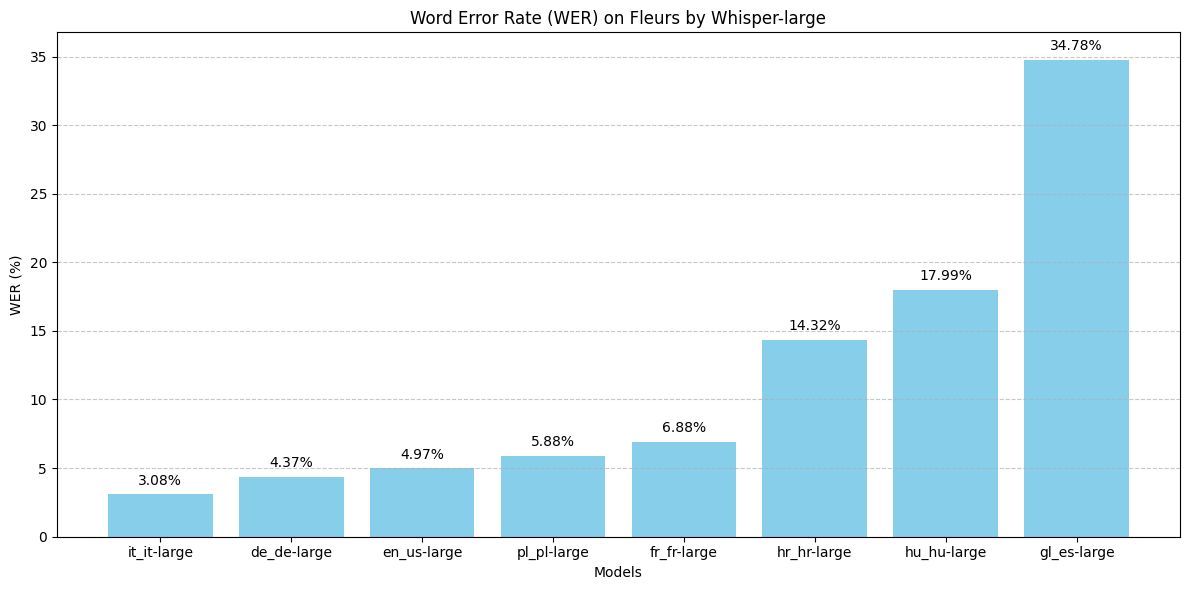

In [34]:
# for whatever reason large and large-v2 outputs are identical -- probably a mistake on my part

import matplotlib.pyplot as plt

# WER results to visualize
wer_results =  {
     "it_it-large": 3.08,
     "de_de-large": 4.37,
     "en_us-large": 4.97,
     "pl_pl-large": 5.88,
     "fr_fr-large": 6.88,
     "hr_hr-large": 14.32,
     "hu_hu-large": 17.99,
     "gl_es-large": 34.78
 }


labels = list(wer_results.keys())
wer_percentages = list(wer_results.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, wer_percentages, color='skyblue')
plt.xlabel('Models')
plt.ylabel('WER (%)')
plt.title('Word Error Rate (WER) on Fleurs by Whisper-large')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(wer_percentages) + 2)

for i, wer in enumerate(wer_percentages):
    plt.text(i, wer + 0.5, f'{wer:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()